In [1]:
from IPython.display import HTML, display
from datetime import datetime, timedelta
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import os

In [2]:
SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc("font", size=SMALL_SIZE)
plt.rc("xtick", labelsize=SMALL_SIZE)
plt.rc("ytick", labelsize=SMALL_SIZE)
plt.rc("legend", fontsize=SMALL_SIZE)
plt.rc("axes", labelsize=MEDIUM_SIZE)
plt.rc("axes", titlesize=BIGGER_SIZE)

In [3]:
CONFIG_FILE = "config.json"
LIBOR_CSV = "fred_historical_USD1MTD156N.csv"

In [4]:
START_DATE = datetime(1999, 12, 31)
END_DATE = datetime(2019, 1, 1)

In [5]:
YEARS_TO_STUDY = [
    2000,
    2004,
    2008,
    2011,
    2016,
    2018
]

In [6]:
S_P500 = "^GSPC"
STOCKS = [
    "AMZN",
    "AAPL",
    "INTC",
    "MSFT",
    "NVDA"
]
SYMBOLS = [S_P500] + STOCKS

In [7]:
def try_live_load(config_file):
    if os.path.exists(config:= os.path.join(os.getcwd(), config_file)):
        with open(config) as config_file:
            config = json.load(config_file)
            if "API_KEY" in config:
                return pd.read_json(F"https://api.tradingeconomics.com/fred/historical/USD1MTD156N?c={config['API_KEY']}").set_index(keys="date")
    return None

In [8]:
def get_risk_free_data(data_file=LIBOR_CSV, config_file=CONFIG_FILE, from_date=START_DATE+timedelta(days=1), to_date=END_DATE, keep=["value"]):
    df = try_live_load(config_file)
    if not isinstance(df, pd.DataFrame) and os.path.exists(file:= os.path.join(os.getcwd(), data_file)):
        df = pd.read_csv(file, index_col="date")
    elif not isinstance(df, pd.DataFrame):
        raise Exception("LIBOR rate data could not be imported")

    return df[keep].rename(columns={column: (F"LIBOR {column}" if len(keep) > 1 else "LIBOR") for column in df}).loc[from_date:to_date]

In [9]:
def get_risky_data(symbols, from_date=START_DATE, to_date=END_DATE, keep=["Adj Close"]):
    if isinstance(symbols, str):
        df = web.DataReader(symbols, "yahoo", from_date, to_date)[keep]
        return df.rename(columns={column: (F"{symbols} {column}" if len(keep) > 1 else symbols) for column in df})
    elif isinstance(symbols, list):
        if symbols:
            df = web.DataReader(symbols[0], "yahoo", from_date, to_date)[keep]
            df.rename(columns={column: (F"{symbols[0]} {column}" if len(keep) > 1 else symbols[0]) for column in df}, inplace=True)
            for s in symbols[1:]:
                temp = web.DataReader(s, "yahoo", from_date, to_date)[keep]
                temp.rename(columns={column: (F"{s} {column}" if len(keep) > 1 else s) for column in temp}, inplace=True)

                df = pd.merge(df, temp, how="inner", on="Date")
            return df
        else: raise ValueError("list of 'symbols' must not be empty")
    else:
        raise TypeError("'symbols' must be either a string or list of symbols")

In [10]:
stock_data = get_risky_data(SYMBOLS).sort_index()
display(HTML(stock_data.head().to_html()))

,^GSPC,AMZN,AAPL,INTC,MSFT,NVDA
Date,,,,,,
1999-12-31,1469.250000,76.1250,0.786033,25.017094,36.777351,0.898277
2000-01-03,1455.219971,89.3750,0.855796,26.441767,36.718292,0.895884
2000-01-04,1399.420044,81.9375,0.783644,25.207062,35.477947,0.871962
2000-01-05,1402.109985,69.7500,0.795111,25.415989,35.852005,0.843256
2000-01-06,1403.449951,65.5625,0.726304,23.934347,34.651024,0.788235


In [11]:
libor_data = get_risk_free_data().sort_index()
display(HTML(libor_data.head().to_html()))

libor_data = np.log(libor_data/100 + 1)
display(HTML(libor_data.head().to_html()))

,LIBOR
date,
2000-01-04,5.81000
2000-01-05,5.79250
2000-01-06,5.79125
2000-01-07,5.79125
2000-01-10,5.78125


,LIBOR
date,
2000-01-04,0.056475
2000-01-05,0.056309
2000-01-06,0.056298
2000-01-07,0.056298
2000-01-10,0.056203


In [12]:
libor_daily = libor_data.groupby(by=libor_data.index.year).apply(lambda df: df.mean()/360)
display(HTML(libor_daily.to_html()))

,LIBOR
date,
2000,0.000173
2001,0.000105
2002,0.000049
2003,0.000033
2004,0.000041
2005,0.000092
2006,0.000138
2007,0.000142
2008,0.000073


In [13]:
libor_monthly = libor_data.groupby(by=libor_data.index.year).apply(lambda df: df.mean()/12)
display(HTML(libor_monthly.to_html()))

,LIBOR
date,
2000,0.005179
2001,0.003165
2002,0.001460
2003,0.001001
2004,0.001241
2005,0.002775
2006,0.004141
2007,0.004262
2008,0.002204


In [14]:
K_daily = np.log(stock_data / stock_data.shift(1))
display(HTML(K_daily.head().to_html()))

,^GSPC,AMZN,AAPL,INTC,MSFT,NVDA
Date,,,,,,
1999-12-31,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-03,-0.009595,0.160464,0.085034,0.055385,-0.001607,-0.002667
2000-01-04,-0.039099,-0.086884,-0.088077,-0.047821,-0.034364,-0.027065
2000-01-05,0.001920,-0.161039,0.014527,0.008254,0.010488,-0.033476
2000-01-06,0.000955,-0.061914,-0.090514,-0.060064,-0.034072,-0.067474


In [15]:
stock_data_eom = stock_data.groupby(by=[stock_data.index.year, stock_data.index.month]).last()
display(HTML(stock_data_eom.head().to_html()))
K_monthly = np.log(stock_data_eom / stock_data_eom.shift(1))
display(HTML(K_monthly.head().to_html()))

In [16]:
def mvp(C_inv, m, ones):
    sigma = np.squeeze(1 / np.sqrt(ones.T @ C_inv @ ones))
    w = sigma ** 2 * (C_inv @ ones)
    mu = np.squeeze(m.T @ w)
    return w, sigma, mu

In [17]:
def mp(C, C_inv, m, R, ones):
    m_ex = m - R * ones

    w = (1 / np.squeeze(ones.T @ C_inv @ m_ex)) * (C_inv @ m_ex)
    sigma = np.squeeze(np.sqrt(w.T @ C @ w))
    mu = np.squeeze(m.T @ w)
    return w, sigma, mu

In [18]:
def generate_efficient_frontier(C_inv, m, mu_MVP, mu_M):
    m_bar = np.concatenate((m, ones), axis=1)
    
    B = m_bar.T @ C_inv @ m_bar
    B_inv = np.linalg.inv(B)

    G = B_inv @ m_bar.T @ C_inv @ m_bar @ B_inv

    a = G[0, 0]
    d = G[0, 1]

    mu = np.linspace(mu_MVP, mu_M*(1.5 if mu_M > 0 else .5), 1000)
    sigma = np.sqrt(a*(mu + (d/a))**2 + (1/a)*np.linalg.det(G))
    return sigma, mu

In [19]:
def capm(mu_M, R, sigma_M, sigma_v):
    beta = np.linspace(0, max(sigma_v)/sigma_M, 1000)
    mu_v = beta * (mu_M - R) + R
    return beta, mu_v

[[0.06365994 0.02940102 0.03066055 0.02691077 0.03817523]
 [0.02940102 0.06395759 0.03453594 0.02358166 0.03431897]
 [0.03066055 0.03453594 0.04376432 0.02692746 0.03293383]
 [0.02691077 0.02358166 0.02692746 0.03572983 0.03208028]
 [0.03817523 0.03431897 0.03293383 0.03208028 0.0745743 ]]
[[ 0.08041848]
 [ 0.09336964]
 [ 0.22092836]
 [ 0.61504329]
 [-0.00975976]]
Adjusting R:
	LIBOR rate: 0.00017264348302361884 >~ mu_MVP -0.0036698473662272104


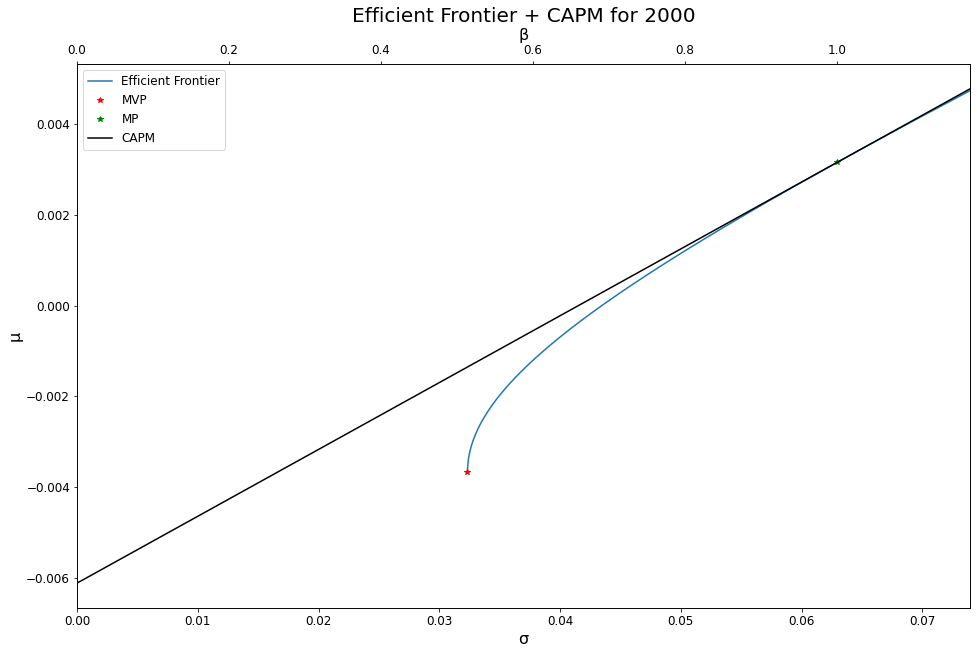

,Year,σ_MVP,μ_MVP,LIBOR,R,σ_M,μ_M
0,2000,0.032334,-0.00367,0.000173,-0.006116,0.062949,0.003157



[[0.02693192 0.0117833  0.01176373 0.00992431 0.01742427]
 [0.0117833  0.02498123 0.0110881  0.0084845  0.01549811]
 [0.01176373 0.0110881  0.01924229 0.0097626  0.0191474 ]
 [0.00992431 0.0084845  0.0097626  0.01074926 0.01158651]
 [0.01742427 0.01549811 0.0191474  0.01158651 0.03997381]]
[[ 0.02060616]
 [ 0.06999948]
 [ 0.07881747]
 [ 0.86719908]
 [-0.03662219]]


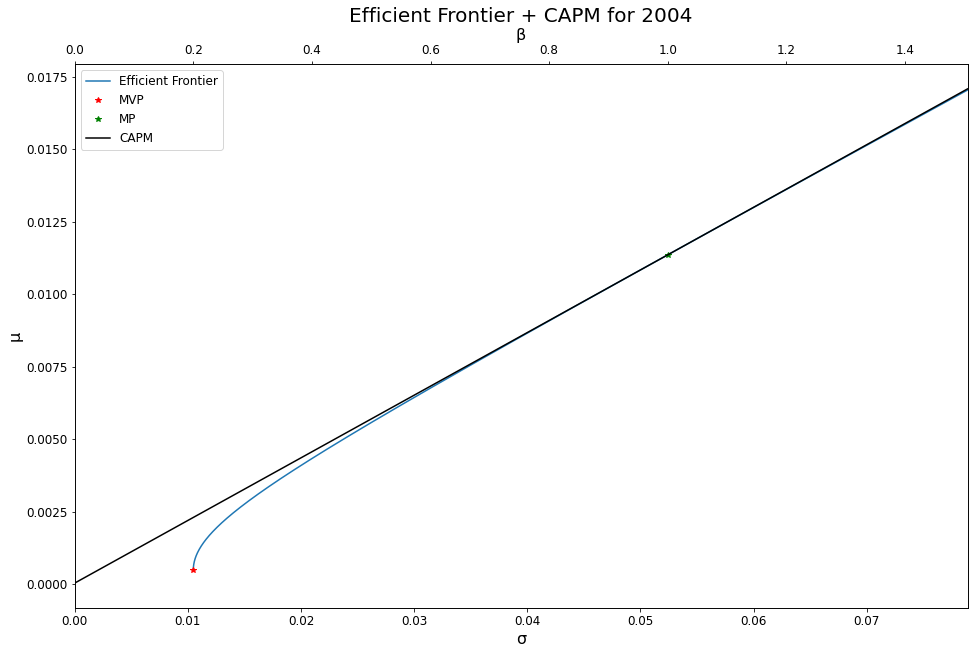

,Year,σ_MVP,μ_MVP,LIBOR,R,σ_M,μ_M
0,2004,0.010482,0.000494,0.000041,0.000041,0.052415,0.011363



[[0.04131767 0.03179377 0.02936148 0.02843447 0.03235683]
 [0.03179377 0.03699773 0.02784259 0.02611767 0.03083635]
 [0.02936148 0.02784259 0.03341758 0.02733157 0.0343007 ]
 [0.02843447 0.02611767 0.02733157 0.0302417  0.02880005]
 [0.03235683 0.03083635 0.0343007  0.02880005 0.05423302]]
[[-0.02770825]
 [ 0.20938806]
 [ 0.27457915]
 [ 0.59896522]
 [-0.05522417]]
Adjusting R:
	LIBOR rate: 7.346458134416215e-05 >~ mu_MVP -0.002326866940802274


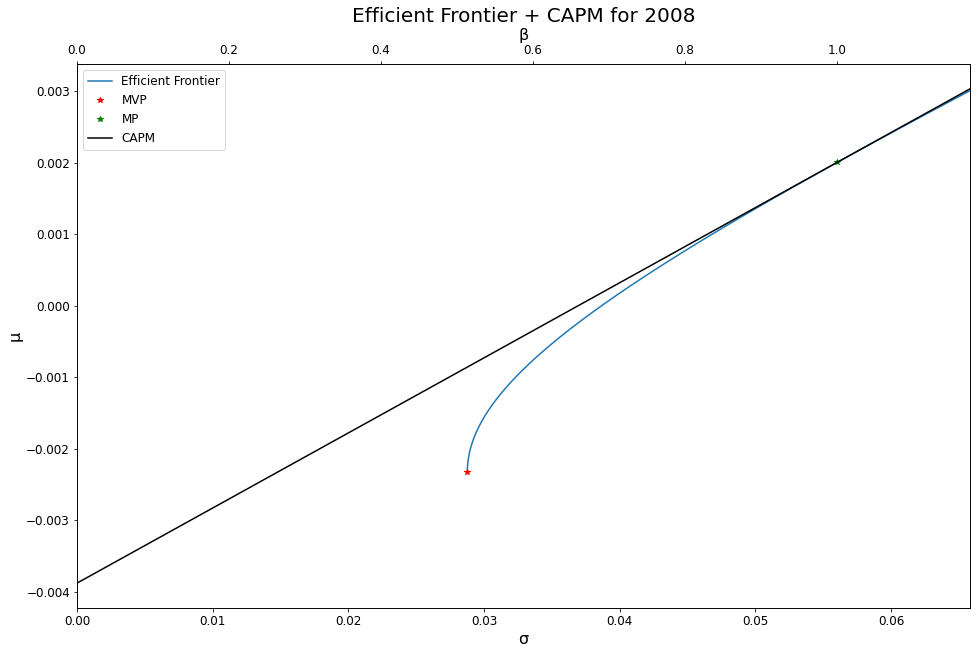

,Year,σ_MVP,μ_MVP,LIBOR,R,σ_M,μ_M
0,2008,0.028767,-0.002327,0.000073,-0.003878,0.05602,0.002005



[[0.02433644 0.01462046 0.01349537 0.01413095 0.01915302]
 [0.01462046 0.01653582 0.01202798 0.01191036 0.01769999]
 [0.01349537 0.01202798 0.01714937 0.01295401 0.01825781]
 [0.01413095 0.01191036 0.01295401 0.01478702 0.01751321]
 [0.01915302 0.01769999 0.01825781 0.01751321 0.03605108]]
[[-0.02821571]
 [ 0.37837758]
 [ 0.24358447]
 [ 0.55681701]
 [-0.15056335]]


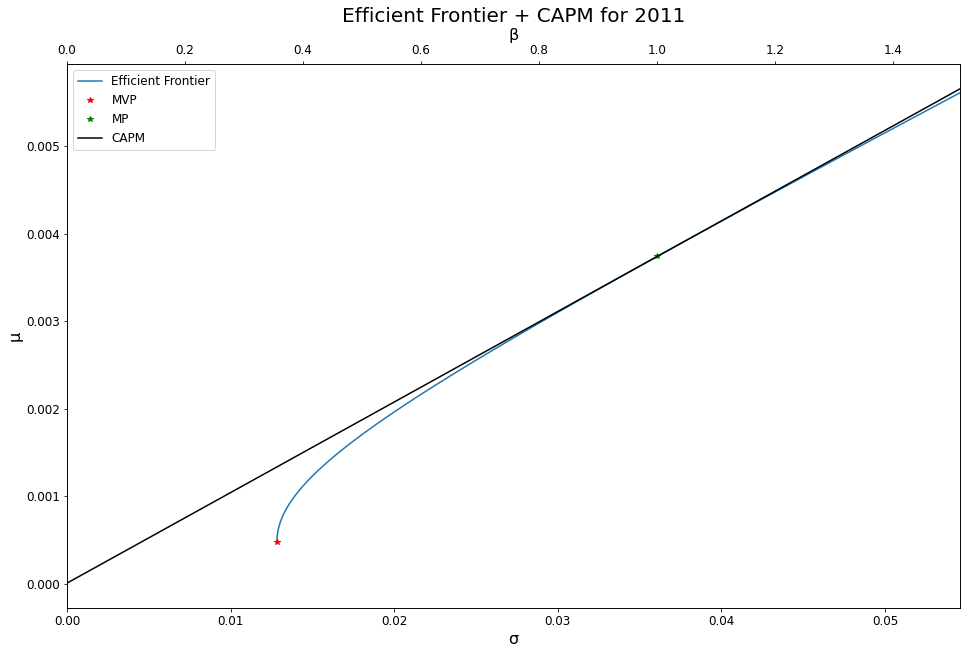

,Year,σ_MVP,μ_MVP,LIBOR,R,σ_M,μ_M
0,2011,0.012825,0.000478,0.000006,0.000006,0.036071,0.003739



[[0.01868182 0.00990377 0.00983906 0.01156123 0.01185528]
 [0.00990377 0.0147233  0.00986739 0.01020092 0.01110203]
 [0.00983906 0.00986739 0.01431989 0.0111375  0.01318145]
 [0.01156123 0.01020092 0.0111375  0.01430902 0.01217839]
 [0.01185528 0.01110203 0.01318145 0.01217839 0.02798887]]
[[ 0.12780177]
 [ 0.32541101]
 [ 0.32575459]
 [ 0.2367158 ]
 [-0.01568316]]


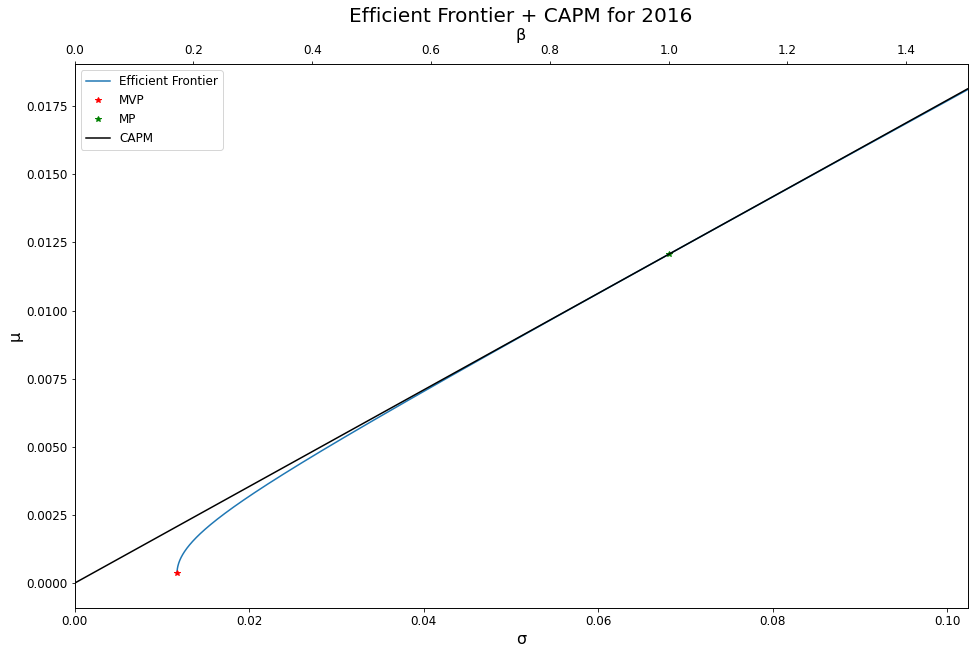

,Year,σ_MVP,μ_MVP,LIBOR,R,σ_M,μ_M
0,2016,0.011726,0.000371,0.000014,0.000014,0.068063,0.012059



[[0.02277627 0.01650312 0.01558922 0.0177122  0.02148433]
 [0.01650312 0.01812623 0.01443817 0.0149899  0.01716238]
 [0.01558922 0.01443817 0.0213637  0.01555381 0.0190885 ]
 [0.0177122  0.0149899  0.01555381 0.0177865  0.01873816]
 [0.02148433 0.01716238 0.0190885  0.01873816 0.03174861]]
[[-0.04184096]
 [ 0.43799907]
 [ 0.20068292]
 [ 0.50442114]
 [-0.10126218]]


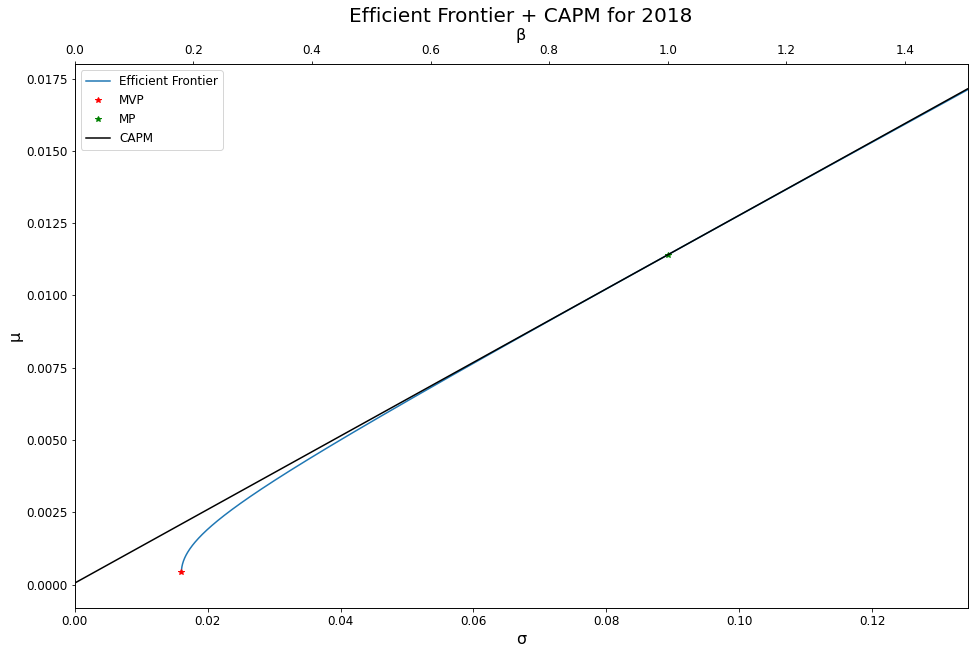

,Year,σ_MVP,μ_MVP,LIBOR,R,σ_M,μ_M
0,2018,0.016058,0.000423,0.000056,0.000056,0.089256,0.011407


In [21]:
for year in YEARS_TO_STUDY:
    df = pd.DataFrame(data={"Year": [year]})

    K = K_daily[STOCKS].loc[datetime(year, 1, 1):datetime(year+1, 1, 1)]

    ## 1
    m = K.mean().to_frame(name="m")

    C = np.cov(K.values, rowvar=False)
    print(np.sqrt(C))
    ## 2
    ones = np.ones((C.shape[0], 1))
    C_inv = np.linalg.inv(C)

    w_MVP, sigma_MVP, mu_MVP = mvp(C_inv, m.values, ones)

    print(w_MVP)
    df["σ_MVP"] = sigma_MVP
    df["μ_MVP"] = mu_MVP

    R = np.squeeze(libor_daily.loc[year].values)
    df["LIBOR"] = R
    if R >= (.9 if mu_MVP > 0 else 1.1)*mu_MVP:
        print("Adjusting R:")
        print(F"\tLIBOR rate: {R} >~ mu_MVP {mu_MVP}")
        R = ((1/3) if mu_MVP > 0 else (5/3))*mu_MVP
    df["R"] = R

    w_M, sigma_M, mu_M = mp(C, C_inv, m.values, R, ones)

    df["σ_M"] = sigma_M
    df["μ_M"] = mu_M

    ## 3
    sigma_v, mu_v = generate_efficient_frontier(C_inv, m.values, mu_MVP, mu_M)
    beta, mu_v_capm = capm(mu_M, R, sigma_M, sigma_v)

    fig = plt.figure(figsize=(16, 10))
    ax1 = fig.add_subplot(111)

    ef = ax1.plot(sigma_v, mu_v, label="Efficient Frontier")
    mvp_p = ax1.plot(sigma_MVP, mu_MVP, "r*", label="MVP")
    mp_p = ax1.plot(sigma_M, mu_M, "g*", label="MP")

    ax2 = ax1.twiny()
    capm_l = ax2.plot(beta, mu_v_capm, "black", label="CAPM")

    lines = ef + mvp_p + mp_p + capm_l
    ax1.legend(lines, [l.get_label() for l in lines])

    ax1.set_title(F"Efficient Frontier + CAPM for {year}")
    ax1.set_xlabel("σ")
    ax2.set_xlabel("β")
    ax1.set_ylabel("μ")
    ax1.set_xlim(0, max(sigma_v))
    ax2.set_xlim(min(beta), max(beta))
    plt.show()

    display(HTML(df.to_html()))

    print()